In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os

%load_ext autoreload
%autoreload 2

# Cross testing of methods

In [2]:
data_set = "breast_cancer"
cf_amount = 25
random_state = 42

match data_set:
    case "breast_cancer":
        X, true_y = load_breast_cancer(return_X_y=True)
        nc = 2
    case "blobs":
        nc = 3
        X, true_y = make_blobs(centers=nc, cluster_std=2, n_features=2, n_samples=250, random_state=random_state)

#X, true_y = load_wine(return_X_y=True)
# X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)


random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

In [3]:
def pickle_cfs(cf_obj):
    name = cf_obj['name']
    p = pathlib.Path(f'./testdata/cfs/{data_set}/{name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    p = pathlib.Path(f'./testdata/eval/{data_set}/{method_name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

## Baseline

In [4]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 163 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (172) CFs (0)
Re-training surrogate model with data size: 172
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (147)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 192
Best instance score 0.0000 (X 0.99387 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 192
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (1) Unique overall (1)
Generated random instances: (127)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 212
Best instance score 0.0000 (X 0.99387 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 212
--- epoch 3 ----
Generating neighbors for 20 n

100%|██████████| 25/25 [00:00<00:00, 322.92it/s]


## Baycon

In [5]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 163 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (172) CFs (27)
Re-training surrogate model with data size: 172
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (148)
Predicted top: 20 Counterfactuals: 14
Found new best [-1.40204706  1.34975704], with fitness score 0.1475 (X 0.89401 Y 0.33 F 0.5), oversampling
Known alternatives: 192
Best instance score 0.1475 (X 0.89401 Y 0.33 F 0.5), found on epoch: 1
Re-training surrogate model with data size: 202
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (2) Unique overall (5)
Generated random instances: (125)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 212
Best instance score 0.1475 (X 0.89401 Y 0.33 F 0.5), found on epoch: 1
Re-training surrogat

100%|██████████| 25/25 [00:00<00:00, 281.97it/s]

[[array([1.96124527, 2.25243014, 2.22331165, 2.19419316, 2.16507468,
       2.13595619, 2.1068377 , 2.07771922, 2.04860073, 2.01948224,
       1.99036375, 1.93212678, 1.90300829, 1.87388981, 1.84477132,
       1.81565283, 2.83479988, 2.80568139, 2.71832593, 2.68920744,
       2.7765629 , 2.74744442, 2.60185198, 2.57273349, 2.54361501,
       2.51449652, 2.48537803, 2.45625955, 2.66008896, 2.63097047,
       2.39802257, 2.42714106, 2.36890409, 2.3397856 , 2.28154862,
       2.31066711, 2.86391837]), array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), array([-1.31897417, -1.11800355, -1.10964313, -1.11635692, -1.14330744,
       -1.16675519, -1.18352627, -1.20273852, -1.22759508, -1.26644354,
       -1.29505681, -1.35138948, -1.38470578, -1.41865388, -1.453179  ,
       -1.48959321, -1.11821806, -1.11481581, -1.08515346, -1.08773787,


## CFDE

In [6]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y)
pickle_res(res, cfde['name'])

Starting on: CF-DE
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 271.27it/s]


## CFAE

In [7]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y)
pickle_res(res, cfae['name'])

Starting on: CF-AE
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 282.38it/s]


## NeighborSearch

In [8]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 355.21it/s]


## Dice Mod

In [9]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from lib.util import sparsity_fix


dice_cfs = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y)
pickle_res(res, dice_mod['name'])


dice_cfs_fixed =  []
for cf in dice_cfs:
    fixed = sparsity_fix(cf.cf, X[cf.instance, :].reshape(1, -1), km)
    new_cf = CounterfactualData(
        fixed, 
        cf.instance, cf.target, cf.instance_label
    )
    dice_cfs_fixed.append(new_cf)



dice_mod_sparsity_fix = {
    "name": "dice_mod_sparsity_fix",
    "counterfactuals": dice_cfs_fixed
}

pickle_cfs(dice_mod_sparsity_fix)

res, _ = run(dice_mod_sparsity_fix, centers, X, y)
pickle_res(res, dice_mod_sparsity_fix['name'])

X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 118, score: 0.7551766966245153
(1, 2)
[array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 102, score: 0.5930461810895982
(1, 2)
[array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 140, score: 0.7823120621616944
(1, 2)
[array([0], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 116, score: 0.7768058531011505
(1, 2)
[array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 118, score: 0.830914384592562
(1, 2)
[array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 102, score: 0.6916660852034707
(1, 2)
[array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 143, score: 0.7902932184773327
(1, 2)
[array([0], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 121, score: 0.8826967849470251
(1, 2)
[array([0], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 102, score: 0.707164303363049
(1, 2)
[array([0], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 147, score: 0.6635043368936008
(1, 2)
[array([

100%|██████████| 25/25 [00:00<00:00, 602.02it/s]


Original counterfactual: [[-0.71598275 -0.31845562]]
instance: [[-0.54392915  1.34975704]]
Original cluster: [1]
costs: [0. 0.]
Fixed: [[-0.54392915 -0.31845562]]
costs: [0.1720536]
Fixed: [[-0.54392915  1.34975704]]
break with [[-0.54392915 -0.31845562]]
Original counterfactual: [[ 0.00651431 -0.59882112]]
instance: [[1.00651424 0.4011788 ]]
Original cluster: [1]
costs: [0. 0.]
Fixed: [[ 1.00651424 -0.59882112]]
break with [[ 0.00651431 -0.59882112]]
Original counterfactual: [[-0.79019301  0.59153659]]
instance: [[-0.77070547 -1.00107194]]
Original cluster: [0]
costs: [0. 0.]
Fixed: [[-0.77070547  0.59153659]]
costs: [0.01948754]
Fixed: [[-0.77070547 -1.00107194]]
break with [[-0.77070547  0.59153659]]
Original counterfactual: [[-0.57171223 -0.40041762]]
instance: [[-0.35550581  1.06308055]]
Original cluster: [1]
costs: [0. 0.]
Fixed: [[-0.35550581 -0.40041762]]
costs: [0.21620642]
Fixed: [[-0.35550581  1.06308055]]
break with [[-0.35550581 -0.40041762]]
Original counterfactual: [[-0.

100%|██████████| 25/25 [00:00<00:00, 559.80it/s]


In [10]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
import torch

dice_cfs = []
count = 10
torch.manual_seed(42)

for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([random_opt(instance, gainer.gain)[0][0]  for _ in range(count)])
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod_random",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y)
pickle_res(res, dice_mod['name'])

X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 131, score: 0.7874297793359816
iter: 132, score: 0.7869239224508296
iter: 124, score: 0.7875625833752598
iter: 123, score: 0.7869678558811357
iter: 123, score: 0.7858006246800876
iter: 121, score: 0.7851279850416405
iter: 130, score: 0.7868753749505193
iter: 128, score: 0.7872971211916419
iter: 126, score: 0.7845405102270115
iter: 120, score: 0.7865079385875166
(10, 2)
[array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32), array([1], dtype=int32)]
X: (250, 2)
C: (3, 2)
x: (1, 2)
iter: 125, score: 0.7262702709842883
iter: 120, score: 0.7263180972233726
iter: 127, score: 0.7263456456606865
iter: 122, score: 0.7258664780071454
iter: 125, score: 0.7264338758226243
iter: 125, score: 0.7262374365495413
iter: 133, score: 0.7262119040691224
iter: 115, score: 0.725592146450393
iter: 128, s

100%|██████████| 25/25 [00:00<00:00, 456.43it/s]


## threshold tree / imm

In [4]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
tt_dtc_prime_cfs = []
tt_imm_cfs = []
tt_imm_prime_cfs = []
tt_rf_cfs = []
for cf in cfs:
    tt_cf, tt_cf_prime = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

    tt_imm_cf, tt_imm_cf_prime = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_imm_prime_cfs.append(cf_data)

    rf_cf = tt.find_counterfactuals_rf(X[cf.instance], cf.target)
    cf_data = CounterfactualData(rf_cf, cf.instance, cf.target, cf.instance_label)
    tt_rf_cfs.append(cf_data)



tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y)
pickle_res(res, tt_dtc_prime['name'])


tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y)
pickle_res(res, tt_imm_prime['name'])



tt_rf = {
    "name": "ThresholdTree_RF",
    "counterfactuals": tt_rf_cfs
}
pickle_cfs(tt_rf)

res, _ = run(tt_rf, centers, X, y)
pickle_res(res, tt_rf['name'])

DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9525483304042179
Random Forest accuracy: 0.9947275922671354
DTC accuracy

100%|██████████| 25/25 [00:00<00:00, 27435.27it/s]


Starting on: ThresholdTree_DTC_Post_Proccesing
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 13712.25it/s]


Starting on: ThresholdTree_IMM
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 12211.20it/s]


Starting on: ThresholdTree_IMM_Post_Proccesing
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 15368.25it/s]


Starting on: ThresholdTree_RF
Removing invalid counterfactuals!!!


100%|██████████| 25/25 [00:00<00:00, 14385.73it/s]


# Loading method counterfactuals

In [5]:
methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print(methodNames)

ModuleNotFoundError: No module named 'numpy._core.numeric'

# Loading evaluation results

In [31]:
results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

# Print & plot evaluation results

In [23]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

for i, n in enumerate(returnNames()):
    row = {}
    for m in methodNames:
        # Get the results for the current method m and metric i
        # so res = list of results, one number for each cf for each instance we're explaining
        res = [row[i] for row in results[m]]
        
        # We are getting the mean of ALL CFs for ALL instances
        # Get mean for each instance first
        instance_means = []
        for j in range(cf_amount):
            mean = np.mean(res[j])
            
            # If no CFs were found, res[j] is empty, and np.mean() returns NaN
            if not np.isnan(mean):
                instance_means.append(mean)

        # Finally, get the means of the instance means. If this is a NaN, 
        # no VALID CFs were found for any instance
        row[m] = np.mean(instance_means)

    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=returnNames())
mean_results_df


/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Baycon,dice_mod_sparsity_fix,CF-DE,ThresholdTree_RF,dice_mod,CF-AE,dice_mod_random,ThresholdTree_IMM_Post_Proccesing,Baseline,ThresholdTree_IMM,ThresholdTree_DTC_Post_Proccesing,NeighborSearch,ThresholdTree_DTC
Similarity,1.828488e+00,1.426158,1.667883e+00,1.618503,1.448956,1.181971e+00,1.395918e+00,1.846532,2.025573,0.911781,1.845371,1.714867e+00,1.627299
Minimality,5.000000e-01,0.180000,4.200000e-01,0.033333,0.000000,1.620000e-01,0.000000e+00,0.347826,0.500000,0.500000,0.000000,3.240000e-01,0.000000
Plausibility,-1.320347e+00,-1.684378,-1.778289e+00,-1.688381,-1.572243,-2.063113e+00,-1.619003e+00,-1.490741,-1.256438,-1.655420,-1.270023,-1.559689e+00,-1.610023
Validity,2.418313e-01,1.000000,1.000000e+00,0.600000,1.000000,1.000000e+00,1.000000e+00,0.920000,0.818182,0.120000,0.620000,1.000000e+00,0.440000
Diversity,2.103723e-07,1.072953,4.423883e-17,1.069383,1.077648,1.410538e-15,1.641185e-08,1.071548,0.000005,1.077575,1.073462,2.720682e-08,1.070869


In [24]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

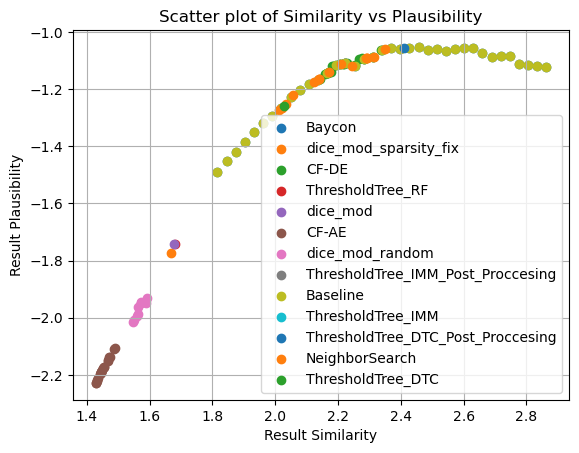

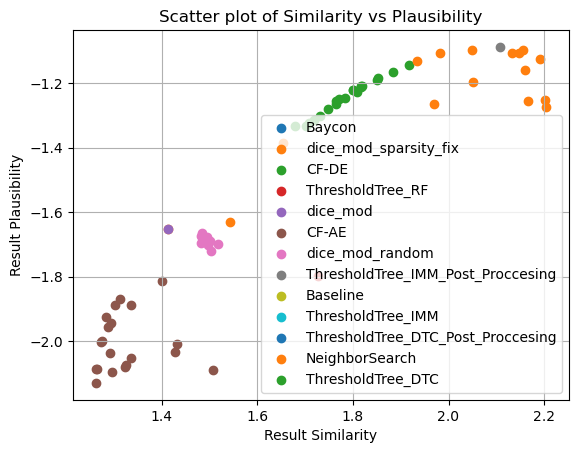

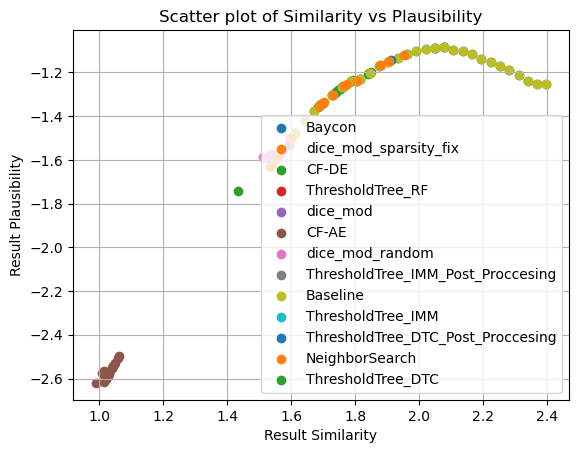

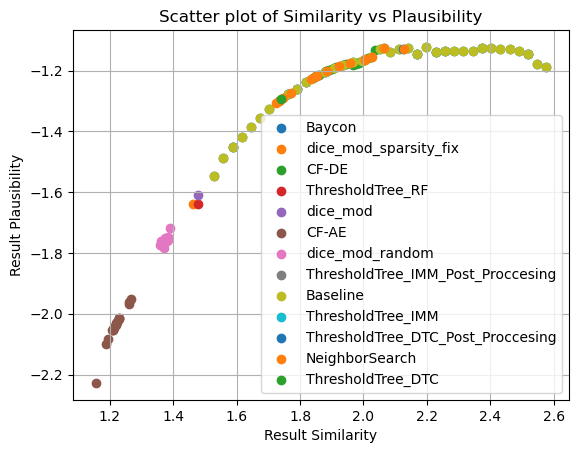

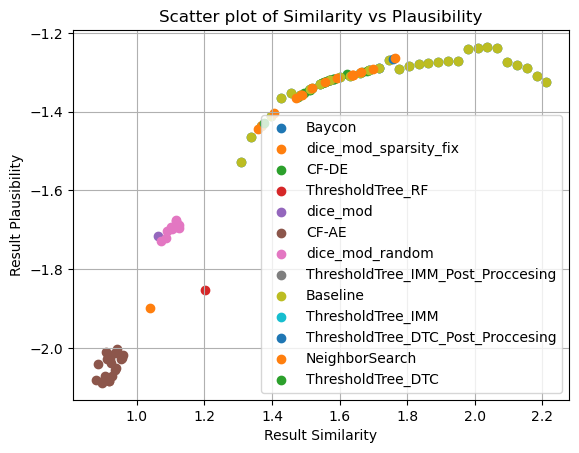

In [25]:
for i in range(5):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

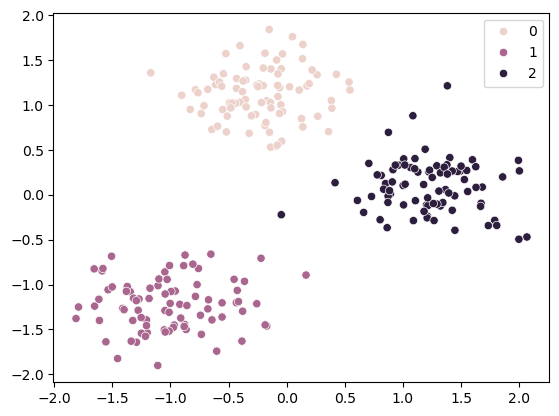

In [26]:
pca = PCA(n_components=2)
if X.shape[1] > 2:
    embed_X = pca.fit_transform(X)
else:
    embed_X = X
    
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

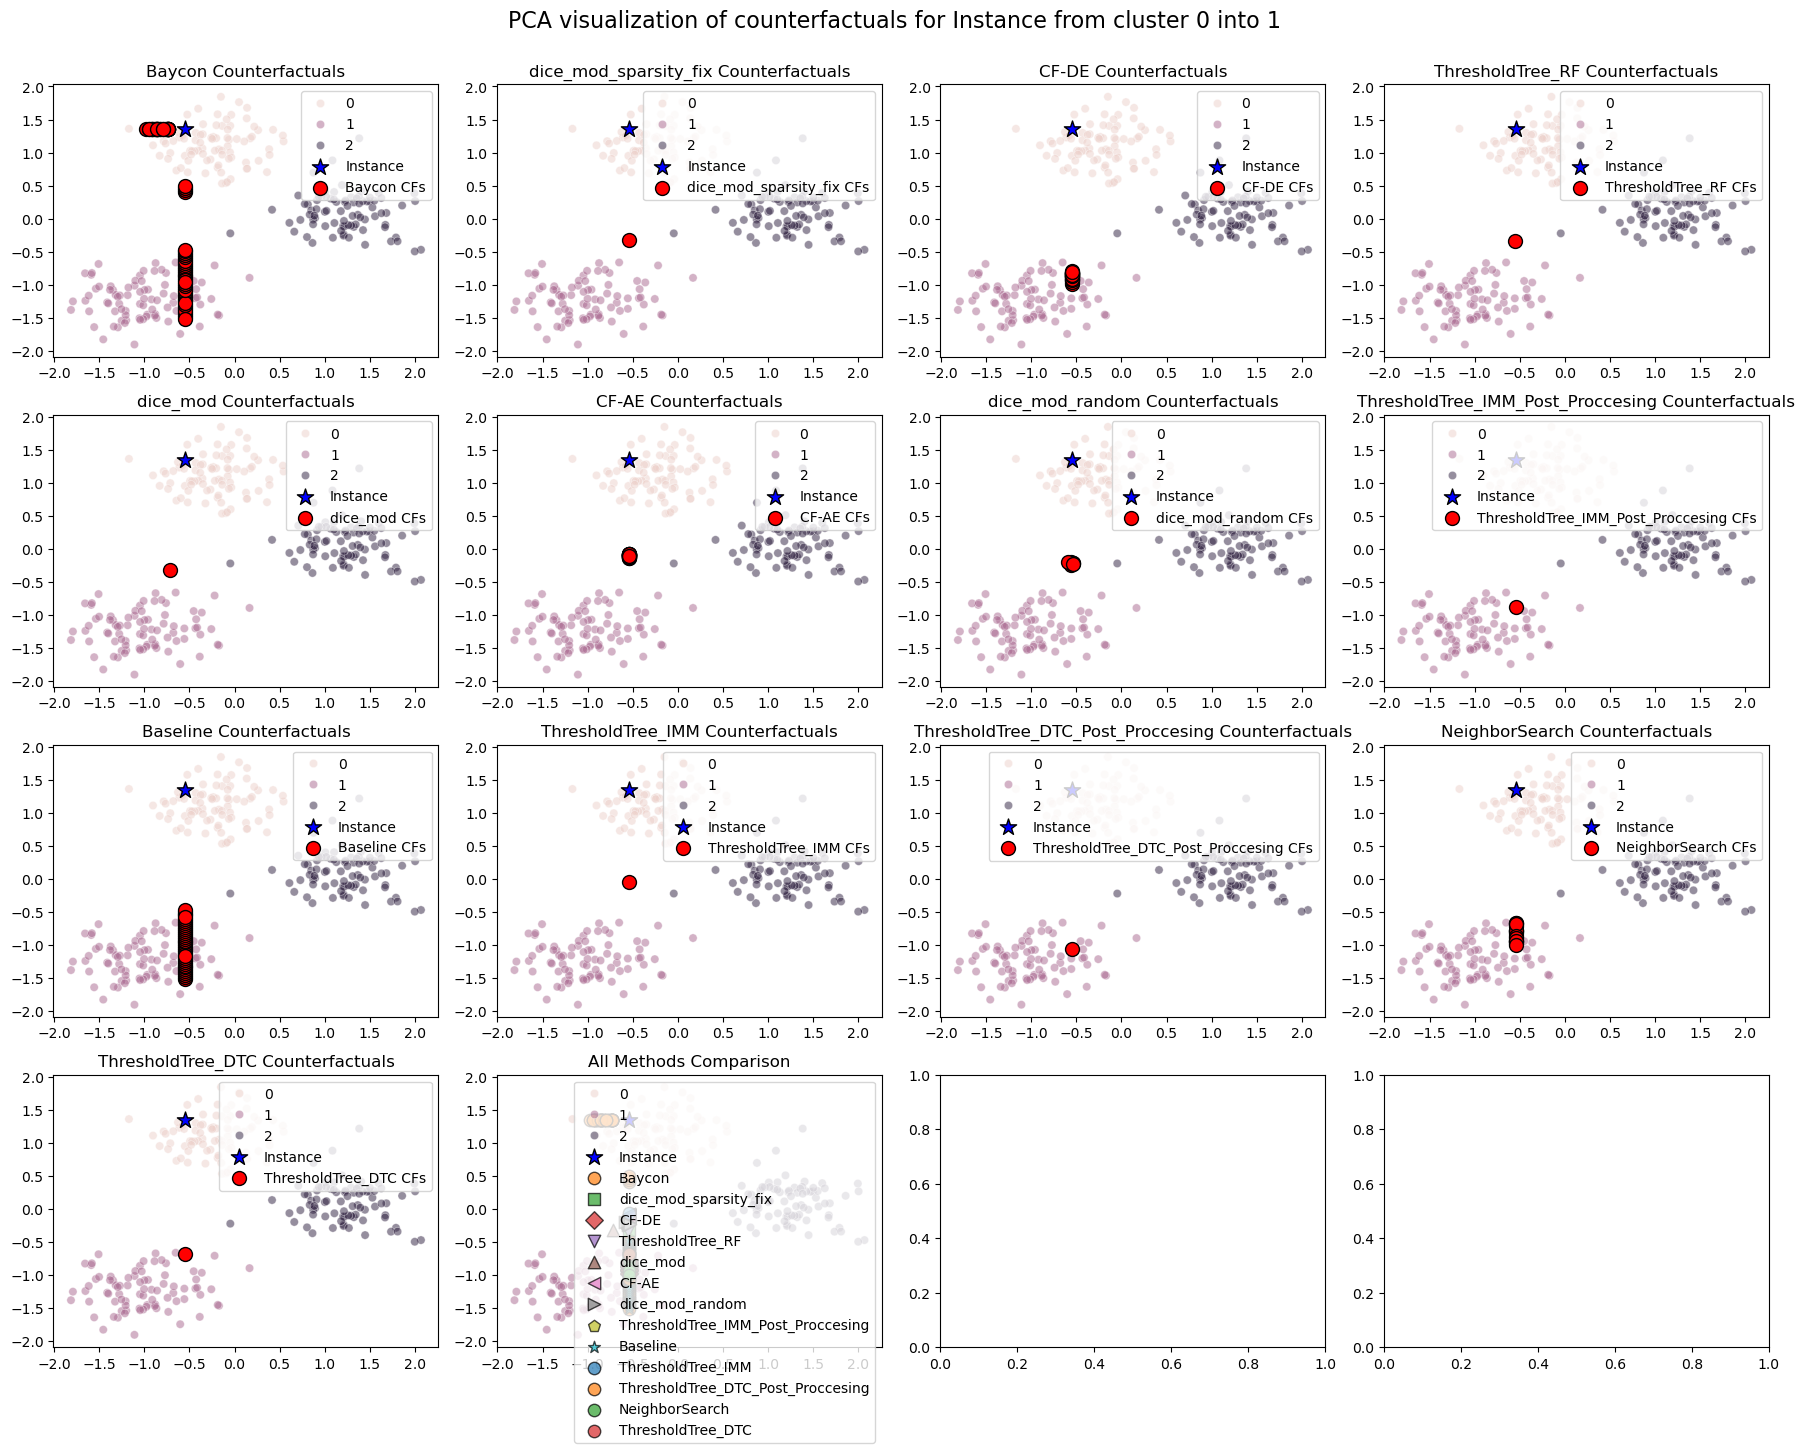

In [27]:
cf_n = 0

fig, axs = plt.subplots(4, 4, figsize=(18, 15))
axs = axs.flatten()

cffDict = methods

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

if X.shape[1] > 2:
    instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
    methods_embedded = [
        (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
else:
    instance_embedded = X[[cffDict[0]['counterfactuals'][cf_n].instance]]
    methods_embedded = [
        (m['name'], np.array(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]

# Base scatterplot of the data
for i in range(len(methods_embedded)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods_embedded):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*', 'o', 'o', 'o', 'o']
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Running time

In [19]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, model=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 167 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (174) CFs (0)
Re-training surrogate model with data size: 174
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (150)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 194
Best instance score 0.0000 (X 0.95544 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 194
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (130)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 214
Best instance score 0.0000 (X 0.95544 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 214
--- epoch 3 ----
Generating neighbors for 20 n